## Flow Analysis Tool: A demo 

FAT, Flow Analysis Tool, is a toolbox that can be used to post-process two and three dimensional simulation data from OpenFOAM. It is mainly focused on high-level manipulation of velocity vector fields, and specifically on order reduction and modelling. In this notebook, the usage and capabilities of the FAT toolbox is demonstrated on a test problem, the flow in a lid-driven cavity.

We import some modules useful later

In [1]:
using PyPlot

### Meshes 

We start by importing the `Meshes` submodule, which manages the mesh loading and manipulation

In [2]:
using FAT

┌ Info: Precompiling FAT [top-level]
└ @ Base loading.jl:1342


We now load an example mesh:

In [3]:
msh = Mesh("../tests/ldc_test_binary")

Mesh object 
  ~ 400 cells                 
  ~ 1640 total faces           
  ~ 760 internal faces
  ~ 880 boundary faces
  ~ 6 patches: 
    ~ left: 20 faces
    ~ right: 20 faces
    ~ bottom: 20 faces
    ~ top: 20 faces
    ~ back0: 400 faces
    ~ front1: 400 faces


Some properties of the mesh are displayed and these can be also obtained from specific methods.

In [4]:
for method in [ncells, npoints, nfaces, nboundaryfaces, ninternalfaces, npatches]
    println(string(method), " = ", method(msh))
end

ncells = 400
npoints = 882
nfaces = 1640
nboundaryfaces = 880
ninternalfaces = 760
npatches = 6


The coordinates of the cell centres can be obtained with:

In [5]:
x, y, z = cellcentres(msh);

These are useful mainly for plotting, e.g.:

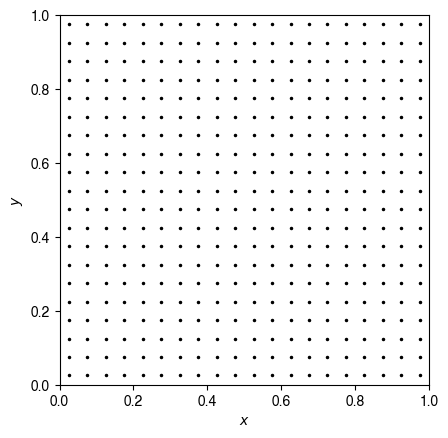

In [6]:
plot(x, y, "k.", ms=3)
xlabel(L"$x$")
ylabel(L"$y$")
xlim(0, 1)
ylim(0, 1)
gca()[:set_aspect](1)

### Patches 

Patches can be found in the dictionary

In [8]:
patches(msh)

Dict{Symbol,FAT.Meshes.Patch} with 6 entries:
  :left   => Patch 'left': first face ID 781, last face ID 800, #faces 20…
  :right  => Patch 'right': first face ID 801, last face ID 820, #faces 20…
  :bottom => Patch 'bottom': first face ID 821, last face ID 840, #faces 20…
  :top    => Patch 'top': first face ID 761, last face ID 780, #faces 20…
  :back0  => Patch 'back0': first face ID 841, last face ID 1240, #faces 400…
  :front1 => Patch 'front1': first face ID 1241, last face ID 1640, #faces 400…

Each patch has specific methods that are used mainly in the library and are probably not needed in user code. For example to get a specific patch we use:

In [9]:
top = patch(msh, :top)

Patch 'top': first face ID 761, last face ID 780, #faces 20


In [10]:
for method in [patchname, firstfaceID, lastfaceID, nfaces]
    println(string(method), " = ", method(top))
end

FAT.Meshes.patchname = top
FAT.Meshes.firstfaceID = 761
FAT.Meshes.lastfaceID = 780
FAT.Meshes.nfaces = 20


#### Loading simulation data

Simulation data can be loaded and manipulated with the `FAT.Simulation` module

In [2]:
using FAT.Simulation

The basic object is `SimulationData`. This accepts as input arguments the path of an openfoam simulation, and a tuple of directions. These indicate the 
directions that we want to load. For a 3D simulation this would be `(1, 2, 3)`, but for 2D simulations we might just need `(1, 2)` or `(1, 3)`, depending on how we have set up the simulation.

In [7]:
sim = SimulationData("../tests/ldc_test_binary/", (1, 2))

OpenFOAM simulation data object 
  ~ case directory /Users/davide/Dropbox/Codes/FAT.jl/tests/ldc_test_binary/
  ~ 11 snapshots available, from: 0.0 to 10.0
  ~ Mesh information:
    ~ Mesh object 
      ~ 400 cells                 
      ~ 1640 total faces           
      ~ 760 internal faces
      ~ 880 boundary faces
      ~ 6 patches: 
        ~ left: 20 faces
        ~ right: 20 faces
        ~ bottom: 20 faces
        ~ top: 20 faces
        ~ back0: 400 faces
        ~ front1: 400 faces


`SimulationData` is a lazy object, so not very interesting. More useful is the function `vfields`, used to load vector fields data. This function accepts as arguments a `SimulationData` object, a symbol for the field we want to load (there must be a corresponding file) and a `AbstractVector` of times that we wish to iterate over. For instance

In [9]:
my_U = FAT._load_data(sim, 1, :U)

2-element Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [0.000259015397, 0.000163142844, -0.00114131597, -0.00345164143, -0.00637455532, -0.00950135629, -0.0124624102, -0.0149527698, -0.0167424154, -0.0176780504  …  0.852350744, 0.847917546, 0.838285482, 0.821949406, 0.796091266, 0.75550283, 0.688596467, 0.572194808, 0.407524201, 0.305169546]
 [-0.000255146514, 0.000103467574, 0.0005629104745430318, 0.000892670232, 0.00105975102, 0.00107585436, 0.000965758515, 0.000758483799, 0.000482986921, 0.00016694022  …  -0.00077230789, -0.00252075338, -0.00477208968, -0.00811771243, -0.0136557976, -0.0234583731, -0.0413908845, -0.0744403286, -0.12786856, -0.147795835]

In [8]:
us = vfields(sim, :U, 2:2:10);

will define an iterator over the velocity fields of the simulation for the snapshots at times 2, 4, 6, 8 and 10. A field iterator is also a lazy object. Files are only loaded when we use the indexing notation. For example:

In [9]:
u_at_t_2 = us[1]

LoadError: MethodError: no method matching ScalarField{2, Float64, Mesh{Float64}}(::SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, ::Mesh{Float64})

Let's see what the `x` component of this field looks like:

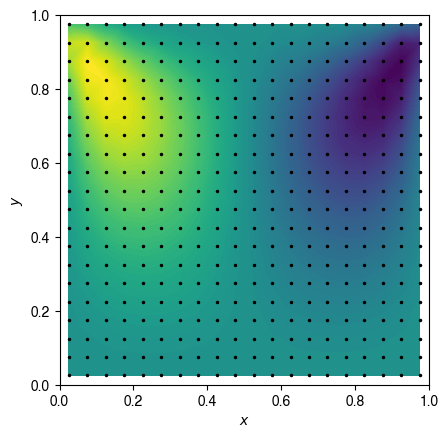

In [13]:
# tricontourf(x, y, u_at_t_2[1].internalField, 100)
tricontourf(x, y, my_U[2], 100)
plot(x, y, "k.", ms=3)
xlabel(L"$x$")
ylabel(L"$y$")
xlim(0, 1)
ylim(0, 1)
gca()[:set_aspect](1)

### Using `VectorFields`

When we index a `FieldIterator` returned by `vfields` we have a `VectorField` object. We can index its `ScalarFields`, the components, like so:

In [24]:
u_at_t_2[1]

FAT.Fields.ScalarField{2,Float64,FAT.Meshes.Mesh{Float64}} object at 15447702254212151623
  ~ Spatial dimensions : 2
  ~ Mesh information:
    ~ Mesh object 
      ~ 400 cells                 
      ~ 1640 total faces           
      ~ 760 internal faces
      ~ 880 boundary faces
      ~ 6 patches: 
        ~ left: 20 faces
        ~ right: 20 faces
        ~ bottom: 20 faces
        ~ top: 20 faces
        ~ back0: 400 faces
        ~ front1: 400 faces


Each `ScalarField` has two fields, the `internalField` and the `boundaryField`

In [25]:
u_at_t_2[1].internalField

400-element Array{Float64,1}:
  0.000259035
  0.000163171
 -0.00114131 
 -0.00345165 
 -0.00637457 
 -0.00950139 
 -0.0124625  
 -0.0149528  
 -0.0167425  
 -0.0176781  
 -0.0176825  
 -0.0167541  
 -0.0149674  
  ⋮          
  0.847522   
  0.852223   
  0.852351   
  0.847918   
  0.838286   
  0.821949   
  0.796091   
  0.755503   
  0.688596   
  0.572195   
  0.407524   
  0.30517    

which contain the cell centered values, and the face centered values of the boundary. To extract the face values for a particular patch we can use the `faceIDs` function, accepting a mesh object and a symbol, like so

In [64]:
for p in [:top, :bottom, :left]
    println(p, " ", u_at_t_2[1].boundaryField[facesIDs(msh, p) - ninternalfaces(msh)])
end

top [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
bottom [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
left [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


We can compute dot products of vector fields

In [65]:
dot(u_at_t_2, u_at_t_2)

0.06326279049336896

and construct a correlation matrix like so

In [67]:
function ccorrmat(us::FAT.Simulation.FieldsIterator)
    N = length(us)
    C = zeros(N, N)
    for i = 1:N
        for j = i:N
            v = dot(us[i], us[j])
            C[i, j] = v
            C[j, i] = v
        end
    end
    return C
end 

ccorrmat (generic function with 1 method)

In [69]:
ccorrmat(us)

5×5 Array{Float64,2}:
 0.0632628  0.0632628  0.0632628  0.0632628  0.0632628
 0.0632628  0.0632628  0.0632628  0.0632628  0.0632628
 0.0632628  0.0632628  0.0632628  0.0632628  0.0632628
 0.0632628  0.0632628  0.0632628  0.0632628  0.0632628
 0.0632628  0.0632628  0.0632628  0.0632628  0.0632628

This is not much intersting, since the flow is stationary in this case.

We can compute the mean field like this

In [71]:
um = mean(us)

FAT.Fields.VectorField{2,Float64,FAT.Meshes.Mesh{Float64}} object at 1702290903819161866
  ~ Spatial dimensions : 2
  ~ Mesh information:
    ~ Mesh object 
      ~ 400 cells                 
      ~ 1640 total faces           
      ~ 760 internal faces
      ~ 880 boundary faces
      ~ 6 patches: 
        ~ left: 20 faces
        ~ right: 20 faces
        ~ bottom: 20 faces
        ~ top: 20 faces
        ~ back0: 400 faces
        ~ front1: 400 faces
